In [2]:
import time
import numpy as np
import pandas as pd
import os
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

from collections import Counter

%matplotlib inline

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

/home/sharadv/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Read in train and test txt files

In [87]:
train_genres = open("train_genres.txt", encoding="utf-8").read().split('\n')
train_plots = open("train_plots.txt", encoding="utf-8").read().split('\n')

In [88]:
train_data = pd.DataFrame({"genres": train_genres, "plots": train_plots})

In [89]:
len(train_data)

204682

In [90]:
train_data.loc[4]["genres"].split(" ")

['Adventure', 'Animation', 'Comedy', '']

In [91]:
test_genres = open("test_genres.txt", encoding="utf-8").read().split('\n')
test_plots = open("test_plots.txt", encoding="utf-8").read().split('\n')

In [92]:
test_data = pd.DataFrame({"genres": test_genres, "plots": test_plots})

In [93]:
len(test_data)

51171

In [94]:
#Concat dataframes
full_data = pd.concat([train_data, test_data], ignore_index= True)

# BRIEF EDA

In [95]:
#Convert genres to list for easier analysis
def list_genres(row):
    return row["genres"].split(" ")[:-1]

In [96]:
full_data["list_genres"] = full_data.apply(lambda row: list_genres(row), axis = 1)

In [97]:
count_dict = defaultdict(int)

In [98]:
#Count num of movies per genre
def dict_count(row):
    global count_dict
    for genre in row["list_genres"]:
        count_dict[genre] += 1

In [99]:
#RUN ONLY ONCE!!!
count_val_series = full_data.apply(lambda row: dict_count(row), axis = 1)

27.88% of the movies are Comedy
45.84% of the movies are Drama
2.37% of the movies are Western
7.00% of the movies are Adventure
6.21% of the movies are Animation
9.71% of the movies are Action
11.18% of the movies are Thriller
8.08% of the movies are Family
11.01% of the movies are Romance
5.89% of the movies are Fantasy
7.77% of the movies are Horror
4.77% of the movies are History
4.95% of the movies are Music
5.60% of the movies are Sci-Fi
2.85% of the movies are War
7.27% of the movies are Crime
2.23% of the movies are Musical
5.18% of the movies are Biography
5.40% of the movies are Mystery
2.37% of the movies are Sport


[Text(0,0,'Comedy'),
 Text(0,0,'Drama'),
 Text(0,0,'Western'),
 Text(0,0,'Adventure'),
 Text(0,0,'Animation'),
 Text(0,0,'Action'),
 Text(0,0,'Thriller'),
 Text(0,0,'Family'),
 Text(0,0,'Romance'),
 Text(0,0,'Fantasy'),
 Text(0,0,'Horror'),
 Text(0,0,'History'),
 Text(0,0,'Music'),
 Text(0,0,'Sci-Fi'),
 Text(0,0,'War'),
 Text(0,0,'Crime'),
 Text(0,0,'Musical'),
 Text(0,0,'Biography'),
 Text(0,0,'Mystery'),
 Text(0,0,'Sport')]

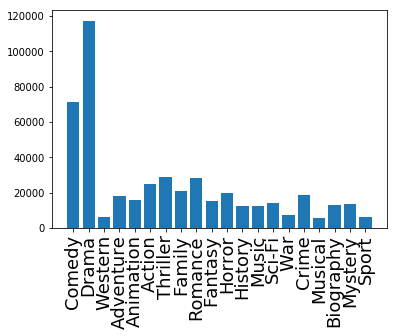

In [100]:
#Count num of movies per genre
for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(full_data), key))



fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict.keys())), list(count_dict.values()))
ax.set_xticks(range(len(count_dict.keys())))
ax.set_xticklabels(list(count_dict.keys()), rotation='vertical', fontsize=18)



Avg num of genres: 1.835858872086706
Median num of genres: 1.0
Max number of genres: 11
Min number of genres: 1


(array([1.29306e+05, 6.44310e+04, 4.38940e+04, 1.29500e+04, 3.96000e+03,
        1.01100e+03, 2.36000e+02, 5.20000e+01, 6.00000e+00, 7.00000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

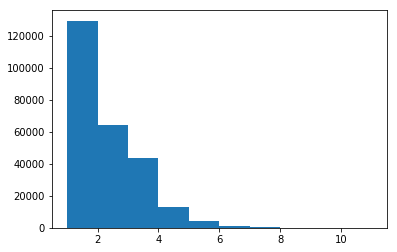

In [101]:
#Number of genres per movie
genre_labels = full_data["list_genres"].str.len()
print("Avg num of genres:", np.mean(genre_labels))
print("Median num of genres:", np.median(genre_labels))
print("Max number of genres:", np.max(genre_labels))
print("Min number of genres:", np.min(genre_labels))


plt.hist(genre_labels)

# CONSOLIDATE Genre Labels

In [102]:
import operator
sorted(count_dict.items(), key=operator.itemgetter(1))[::-1]

[('Drama', 117272),
 ('Comedy', 71341),
 ('Thriller', 28614),
 ('Romance', 28160),
 ('Action', 24854),
 ('Family', 20682),
 ('Horror', 19884),
 ('Crime', 18603),
 ('Adventure', 17921),
 ('Animation', 15880),
 ('Fantasy', 15075),
 ('Sci-Fi', 14332),
 ('Mystery', 13814),
 ('Biography', 13263),
 ('Music', 12675),
 ('History', 12206),
 ('War', 7295),
 ('Sport', 6074),
 ('Western', 6063),
 ('Musical', 5702)]

In [103]:
remove = ["Animation", "Fantasy", "Mystery", 
          "Biography", "Music", "History", "War", "Sport", "Western", "Musical"]

def remove_genres(genres):
    return [x for x in genres if x not in remove]

full_data["list_genres_consol"] = full_data["list_genres"].apply(lambda row: remove_genres(row))

In [105]:
full_data = full_data[full_data.astype(str)["list_genres_consol"] != "[]"]

31.81% of the movies are Comedy
52.28% of the movies are Drama
7.99% of the movies are Adventure
11.08% of the movies are Action
12.76% of the movies are Thriller
9.22% of the movies are Family
12.55% of the movies are Romance
8.86% of the movies are Horror
6.39% of the movies are Sci-Fi
8.29% of the movies are Crime


[Text(0,0,'Comedy'),
 Text(0,0,'Drama'),
 Text(0,0,'Adventure'),
 Text(0,0,'Action'),
 Text(0,0,'Thriller'),
 Text(0,0,'Family'),
 Text(0,0,'Romance'),
 Text(0,0,'Horror'),
 Text(0,0,'Sci-Fi'),
 Text(0,0,'Crime')]

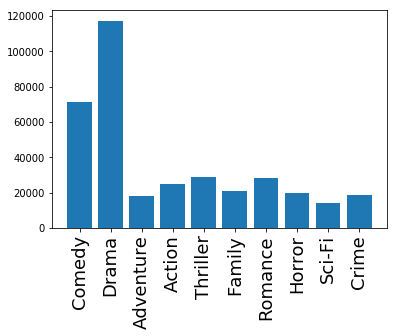

In [186]:
keep = ["comedy", "drama", "adventure", "action", "thriller", "family", "romance", "horror", "crime", "sci-fi", "scifi"]
for key in remove:
    if key in count_dict:
        del count_dict[key]

for key,val in count_dict.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(full_data), key))



fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict.keys())), list(count_dict.values()))
ax.set_xticks(range(len(count_dict.keys())))
ax.set_xticklabels(list(count_dict.keys()), rotation='vertical', fontsize=18)


In [60]:
#average length of plot summary (characters)
avg_num_chars = train_data["plots"].str.len().mean()
max_num_chars = train_data["plots"].str.len().max()
print(f'The average number of characters in a summary is {avg_num_chars}, max is {max_num_chars}')

The average number of characters in a summary is 457.3046736415306, max is 1192


In [63]:
avg_num_words = train_data["plots"].str.count(" ").mean() + 1
max_num_words = train_data["plots"].str.count(" ").max() + 1
median_num_words = train_data["plots"].str.count(" ").median() + 1
avg_num_periods = train_data["plots"].str.count("[\.\?!]").mean()
max_num_periods = train_data["plots"].str.count("[\.\?!]").max()
median_num_periods = train_data["plots"].str.count("[\.\?!]").median()
print(f'The average number of words in a summary is {avg_num_words}, max is {max_num_words}, median is {median_num_words}')
print(f'The average number of sentences in a summary is {avg_num_periods}, max is {max_num_periods}, median is {median_num_periods}')
print(avg_num_words/avg_num_periods)
print(median_num_words/median_num_periods)


The average number of words in a summary is 79.96559479419325, max is 195, median is 72.0
The average number of sentences in a summary is 4.430212142055534, max is 74, median is 4.0
18.05005995877451
18.0


In [64]:
train_data["plots"].str.count("\n").max()

0

In [65]:
#Alternative way to calculate plot length
print(train_data["plots"].str.lower().str.split().str.len().mean()) #Avg words
print(train_data["plots"].str.lower().str.split().str.len().max()) #Max words

78.96578937841653
194


In [21]:
dict_words = Counter(" ".join(train_data["plots"]).split(" "))
print(len(dict_words.keys())) #should be number of unique words
print(sum(dict_words.values())) #should be total number of words

567468
16346270


# Preprocessing

In [108]:
#Lemmetizing Function
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sharadv/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sharadv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [148]:
#Tokenize w/lemmetization AFTER removing stopwords 
#https://machinelearningmastery.com/clean-text-machine-learning-python/
def tokenize(plot, stop_words, lemmatize = False):
    
    def re_sub(pattern, replace):
        return re.sub(pattern, replace, plot)
    
    plot = plot.lower() #lowercase
    plot = re_sub(r"[-+]?[.\d]*[\d]+[:,/.\d]*", "DG") #generic tag for numbers
    plot = re_sub(r"([!?.]){2,}", r"\1") #Convert multiple punctuations to the last punctuation mark
    plot = plot.replace('-',' ') #separating hyphenated words
    plot = plot.replace('_','') #remove underscores
    plot = re_sub(r'(?<!\w)([a-zA-Z])\.', r'\1') #remove periods from abbreviations
    plot = re_sub('[^\w\s\.\?\!\']','') #remove punctuation besides sentence completers and apostrophes
    sentences = nltk.sent_tokenize(plot)
    words = list(map(nltk.word_tokenize, sentences))
    words = [[x for x in w if not x in stop_words] for w in words]
    words = [[x if not x in keep else "genre" for x in w] for w in words]
    if lemmatize:
        output_lem = [nltk.pos_tag(w) for w in words]
        return [[lemmatizer.lemmatize(x[0], pos = nltk2wn_tag(x[1])) for x in w] for w in output_lem]
    else:
        return words

In [206]:
def tokenize_USE(plot):
    def re_sub(pattern, replace):
        return re.sub(pattern, replace, plot)
    
    plot = plot.lower() #lowercase
    plot = re_sub(r"[-+]?[.\d]*[\d]+[:,/.\d]*", "DG") #generic tag for numbers
    plot = re_sub(r"([!?.]){2,}", r"\1") #Convert multiple punctuations to the last punctuation mark
    plot = plot.replace('-',' ') #separating hyphenated words
    plot = plot.replace('_','') #remove underscores
    plot = re_sub(r'(?<!\w)([a-zA-Z])\.', r'\1') #remove periods from abbreviations
    plot = re_sub('[^\w\s\.\?\!\']','') #remove punctuation besides sentence completers and apostrophes
    plot = plot.split()
    plot = [x if x not in keep else "genre" for x in plot]
    return " ".join(plot)

def tokenize_USE_sentence(plot):
    return nltk.sent_tokenize(plot)

In [196]:
nltk.download('punkt')
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /home/sharadv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sharadv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [198]:
ss = "Hello my name is sharad 50 years. I like actionable comedy alot!"
tokenize_USE(ss)

'hello my name is sharad DG years. i like actionable genre alot!'

In [201]:
start = time.time()
full_data["USE_tokens"] = full_data.apply(lambda row: tokenize_USE(row['plots']), axis=1)
end = time.time()
print("Total Time to tokenize plots:", end - start, "seconds")

Total Time to tokenize plots: 30.661588191986084 seconds


In [203]:
start = time.time()
full_data['tokenized_words'] = full_data.apply(lambda row: tokenize(row['plots'], stop, lemmatize = True), axis=1)
end = time.time()
print("Total Time to tokenize plots:", end - start, "seconds")

Total Time to tokenize plots: 1108.0996301174164 seconds


In [214]:
full_data['flattened_tokens'] = full_data.apply(lambda l: [item for sublist in l['tokenized_words'] for item in sublist], axis=1)

In [207]:
start = time.time()
full_data["USE_tokens_sentences"] = full_data.apply(lambda row: tokenize_USE_sentence(row['USE_tokens']), axis=1)
end = time.time()
print("Total Time to tokenize plots:", end - start, "seconds")

Total Time to tokenize plots: 36.75091528892517 seconds


# Binarize labels

In [216]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(full_data["list_genres_consol"])
full_data["binarized_labels"] = labels.tolist()

In [217]:
mlb.classes_

array(['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family',
       'Horror', 'Romance', 'Sci-Fi', 'Thriller'], dtype=object)

In [218]:
labels.shape

(224303, 10)

# Pickle data

In [44]:
full_data.to_pickle("./full_data.pkl")

In [3]:
full_data = pd.read_pickle("./full_data.pkl")

In [7]:
full_data.head()

,genres,plots,list_genres,list_genres_consol,USE_tokens,tokenized_words,USE_tokens_sentences,flattened_tokens,binarized_labels,USE_token_plot_embeddings,USE_tokens_sentences_padded
0,Comedy,A stranded theatrical troupe manages to get ba...,[Comedy],[Comedy],a stranded theatrical troupe manages to get ba...,"[[stranded, theatrical, troupe, manages, get, ...",[a stranded theatrical troupe manages to get b...,"[stranded, theatrical, troupe, manages, get, b...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0.06496927887201309, 0.02937605045735836, 0.0...",[a stranded theatrical troupe manages to get b...
1,Drama,While waiting at the bus stop for the woman he...,[Drama],[Drama],while waiting at the bus stop for the woman he...,"[[wait, bus, stop, woman, intend, marry, jay, ...",[while waiting at the bus stop for the woman h...,"[wait, bus, stop, woman, intend, marry, jay, d...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.03805602714419365, 0.05806170403957367, -0....",[while waiting at the bus stop for the woman h...
3,Drama,Policeman Lasse rehabilitates young prisoners ...,[Drama],[Drama],policeman lasse rehabilitates young prisoners ...,"[[policeman, lasse, rehabilitate, young, priso...",[policeman lasse rehabilitates young prisoners...,"[policeman, lasse, rehabilitate, young, prison...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.031366996467113495, 0.0004756059206556529,...",[policeman lasse rehabilitates young prisoners...
4,Adventure Animation Comedy,Patricia and Isobelle O'Sullivan arrives at th...,"[Adventure, Animation, Comedy]","[Adventure, Comedy]",patricia and isobelle o'sullivan arrives at th...,"[[patricia, isobelle, o'sullivan, arrive, st.,...",[patricia and isobelle o'sullivan arrives at t...,"[patricia, isobelle, o'sullivan, arrive, st., ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.06273579597473145, 0.042697515338659286, -...",[patricia and isobelle o'sullivan arrives at t...
5,Drama,Anna Zaccheo is a beautiful young woman from a...,[Drama],[Drama],anna zaccheo is a beautiful young woman from a...,"[[anna, zaccheo, beautiful, young, woman, work...",[anna zaccheo is a beautiful young woman from ...,"[anna, zaccheo, beautiful, young, woman, work,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.03793998435139656, 0.03065059520304203, -0...",[anna zaccheo is a beautiful young woman from ...


# READ IN UNIVERSAL SENTENCE ENCODER

In [12]:
!pip install tensorflow-hub
import tensorflow_hub as hub
import tensorflow as tf

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


W0330 20:51:24.844583 139980695775040 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [13]:
start = time.time()
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
end = time.time()
print("Total Time to import sentence embeddings:", end - start, "seconds")

Total Time to import sentence embeddings: 6.270820617675781 seconds


In [260]:
#EMBED ENTIRE PLOTS
start = time.time()
messages = np.array(full_data["USE_tokens"])

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

#   for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
#     print("Message: {}".format(messages[i]))
#     print("Embedding size: {}".format(len(message_embedding)))
#     message_embedding_snippet = ", ".join(
#         (str(x) for x in message_embedding[:3]))
#     print("Embedding: [{}, ...]\n".format(message_embedding_snippet))
end = time.time()
print("Total Time to embed entire plots with USE:", end - start, "seconds")

Total Time to embed entire plots with USE: 639.3612117767334 seconds


In [263]:
full_data["USE_token_plot_embeddings"] = message_embeddings.tolist()

In [40]:
#TRUNCATE AND PAD NUM SENTENCES FOR USE_SENTENCE_LEVEL_ENCODING
MAX_SENT = 5
def truncate_and_pad_plots(sentences, max_sent):
    if len(sentences) < max_sent:
        return sentences + ["EMPTY"] * (max_sent - len(sentences))
    elif len(sentences) > max_sent:
        return sentences[0:max_sent]
    else:
        return sentences

start = time.time() 
full_data["USE_tokens_sentences_padded"] = full_data["USE_tokens_sentences"].apply(lambda row: 
                                                                                   truncate_and_pad_plots(row, 
                                                                                                          MAX_SENT))
end = time.time()
print("Total Time to pad and truncate plots for USE:", end - start, "seconds")

Total Time to pad and truncate plots for USE: 0.31798362731933594 seconds


In [10]:
split = np.array_split(full_data, 2)
full_data_sub1 = split[0]
full_data_sub2 = split[1]

In [15]:
#EMBED INDIVID SENTENCES - 1st half
#MAX_SENT = 5
start = time.time()
messages = tf.reshape(np.stack(full_data_sub1["USE_tokens_sentences_padded"]), [-1]) #Make 1 dimensional for tf_HUB, will reshape later

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

#   for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
#     print("Message: {}".format(messages[i]))
#     print("Embedding size: {}".format(len(message_embedding)))
#     message_embedding_snippet = ", ".join(
#         (str(x) for x in message_embedding[:3]))
#     print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

end = time.time()
print("Total Time to embed half the plots with USE:", end - start, "seconds")

Total Time to embed half the plots with USE: 738.8966250419617 seconds


In [17]:
full_data_sub1_embeddings = message_embeddings.reshape(len(full_data_sub1), MAX_SENT, 512)
full_data_sub1_embeddings.shape

(112152, 5, 512)

In [ ]:
#EMBED INDIVID SENTENCES - 2nd half
MAX_SENT = 5
start = time.time()
messages = tf.reshape(np.stack(full_data_sub2["USE_tokens_sentences_padded"]), [-1]) #Make 1 dimensional for tf_HUB, will reshape later

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

#   for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
#     print("Message: {}".format(messages[i]))
#     print("Embedding size: {}".format(len(message_embedding)))
#     message_embedding_snippet = ", ".join(
#         (str(x) for x in message_embedding[:3]))
#     print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

end = time.time()
print("Total Time to embed half the plots with USE:", end - start, "seconds")

In [ ]:
full_data_sub2_embeddings = message_embeddings.reshape(len(full_data_sub2), MAX_SENT, 512)
full_data_sub2_embeddings.shape

In [14]:
mess = np.array([["hello how are you.", "I am doing well"],["whats up my friend", "I am doing well"]])
mess = tf.reshape(mess, [-1])
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  mess_embed = session.run(embed(mess))


# Token analysis

Iterate over tokenized words and create dictionaries that keep track of number of tokens, length of sentences, and sentences per plot summary

In [33]:
word_dict = {}
sent_per_summary_dict = {}
word_per_sent_dict = {}
rows = len(full_data['tokenized_words'])
print(rows)#number of plot summaries
for i in range(len(full_data['tokenized_words'])):
    length = len(full_data['tokenized_words'][i])
    if length in sent_per_summary_dict:
        sent_per_summary_dict[length] += 1
    else:
        sent_per_summary_dict[length] = 1
    for j in range(length):
        word_count = len(full_data['tokenized_words'][i][j])
        if word_count in word_per_sent_dict:
            word_per_sent_dict[word_count] += 1
        else:
            word_per_sent_dict[word_count] = 1
        for word in full_data['tokenized_words'][i][j]:
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1

255853


In [34]:
print(len(word_dict.keys())) #should be number of unique words
print(sum(word_dict.values())) #should be total number of words

244947
12584868


In [35]:
count = 0
twoOrOne = 0
for value in word_dict.values():
    if value == 1:
        count +=1
    if value <3:
        twoOrOne +=1
print(len(word_dict.keys()) - count) # words that appear more than once
print(len(word_dict.keys()) - twoOrOne) # words that appear more than twice

114657
80476


In [36]:
print(len(word_per_sent_dict.keys())) #should be number of unique sentence lengths
print(sum(word_per_sent_dict.values())) #should be number of sentences in all plots
print(max(word_per_sent_dict.keys())) #should be largest sentence length
total = 0
weight_sum = 0
for key, value in word_per_sent_dict.items():
    total += value
    weight_sum += key*value
print(weight_sum/total) #should be average sentence length
#print(word_per_sent_dict)

112
1016033
148
12.386278792125847


In [37]:
print(len(sent_per_summary_dict.keys())) #should be number of unique sentence lengths per summary
print(max(sent_per_summary_dict.keys())) #should be highest amount of sentences per summary
total = 0
weight_sum = 0
for key, value in sent_per_summary_dict.items():
    total += value
    weight_sum += key*value
print(weight_sum/total) #should be average sentence count per summary
#print(sent_per_summary_dict)

26
28
3.971159220333551


# Load GloVe Word Embeddings

In [4]:
#compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings
embeddings_index = {}
GLOVE_DIR = './glove.6B/'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [5]:
#create average word vector. This will later be used in place of unknown words
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), 'r') as f:
    for i, line in enumerate(f):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1

vecs = np.zeros((n_vec, hidden_dim), dtype=np.float32)

with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), 'r') as f:
    for i, line in enumerate(f):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)

average_vec = np.mean(vecs, axis=0)
#print(average_vec)

# Keras Modeling

Based on the above token analysis, we set the following hyperparameters at these initial values

In [6]:
MAX_SENT_LENGTH = 15 #Gets ~80% of sentences
MAX_SENTS = 5 #Gets ~80% of summaries
MAX_NB_WORDS = 80000 #Eliminates words seen two or fewer times
EMBEDDING_DIM = 100

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(full_data['flattened_tokens'])

In [8]:
data = np.zeros((len(full_data), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for summary_num, row in full_data.iterrows():
    for sent_num, sent in enumerate(row['tokenized_words']):
        if sent_num < MAX_SENTS:
            word_num = 0
            words_in_sent = []
            for _, word in enumerate(sent):
                if word_num < MAX_SENT_LENGTH: 
                    if (word in tokenizer.word_index) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[summary_num, sent_num, word_num] = tokenizer.word_index[word]
                        words_in_sent.append(word)
                    else:
                        data[summary_num, sent_num, word_num] = MAX_NB_WORDS
                        words_in_sent.append('UNK')
                    word_num = word_num + 1
            doc_lst.append(words_in_sent)

In [9]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

print('Shape of data tensor:', data.shape)

Total 244947 unique tokens.
Shape of data tensor: (255853, 5, 15)


In [10]:
#leverage our embedding_index dictionary and our word_index to compute our embedding matrix
embedding_matrix = np.zeros((MAX_NB_WORDS+1, EMBEDDING_DIM))
count = 0
unknown =0
added =0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    # words not found in embedding index will be all-zeros.
    if embedding_vector is not None and i < MAX_NB_WORDS:
        embedding_matrix[i] = embedding_vector
        added+=1
    elif i == MAX_NB_WORDS:
        # index MAX_NB_WORDS in data corresponds to 'UNK'
        embedding_matrix[i] = average_vec #use average vector for unknown
        unknown+=1
    else:
        count +=1
print(added) #of the MAX_NB_WORDS most frequent tokens in our corpus, this many have GloVe embeddings
print(unknown)
print(count)

66689
1
178257


In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 127228 which is 51.94 % of total words


In [12]:
#load this embedding matrix into an Embedding layer.
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

embedding_layer = Embedding(MAX_NB_WORDS + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            embeddings_regularizer=l2_reg,
                            mask_zero = True, #determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents
                            trainable=False) #prevent weights from being updated during training

In [13]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix], 
                            input_length=MAX_SENT_LENGTH, 
                            trainable=False)

In [103]:
#https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f
# sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
# embedded_sequences = embedding_layer(sentence_input)
# l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
# sentEncoder = Model(sentence_input, l_lstm)

# review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
# review_encoder = TimeDistributed(sentEncoder)(review_input)
# l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
# preds = Dense(20, activation='softmax')(l_lstm_sent)
# model = Model(review_input, preds)

In [14]:
#https://github.com/Hsankesara/DeepResearch/blob/master/Hierarchical_Attention_Network/attention_with_context.py
#https://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed
from keras import backend as K
from keras import optimizers
from keras.models import Model
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [15]:
# Words level attention model
word_input = Input(shape=(MAX_SENT_LENGTH,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(20, activation='sigmoid')(sent_att)
model = Model(sent_input, preds)

In [16]:
model.compile(loss='binary_crossentropy',optimizer='adam',  metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 15)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 200)            24896600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 300)            421200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 200)            60200     
_________________________________________________________________
attention_with_context_2 (At (None, 200)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                4020      
Total para

# Create train/test split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state=42)

In [23]:
#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.11, random_state=42)

# Training the model

In [24]:
fname = 'han_food'
history = History()
csv_logger = CSVLogger('./{0}_{1}.log'.format(fname, REG_PARAM), separator=',', append=True)

In [25]:
BATCH_SIZE = 50
NUM_EPOCHS = 10

In [26]:
print(x_train.shape)
print(y_train.shape)

(204937, 5, 15)
(204937, 20)


In [27]:
t1 = time.time()

model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=False, 
          callbacks=[history, csv_logger], verbose=2)

t2 = time.time()

Epoch 1/10
 - 445s - loss: 0.2093 - acc: 0.9214
Epoch 2/10
 - 442s - loss: 0.1921 - acc: 0.9266
Epoch 3/10
 - 445s - loss: 0.1852 - acc: 0.9289
Epoch 4/10
 - 446s - loss: 0.1797 - acc: 0.9308
Epoch 5/10
 - 444s - loss: 0.1743 - acc: 0.9327
Epoch 6/10
 - 441s - loss: 0.1691 - acc: 0.9346
Epoch 7/10
 - 442s - loss: 0.1639 - acc: 0.9365
Epoch 8/10
 - 445s - loss: 0.1591 - acc: 0.9383
Epoch 9/10
 - 440s - loss: 0.1547 - acc: 0.9400
Epoch 10/10
 - 442s - loss: 0.1506 - acc: 0.9416


# Evaluation and Metrics

In [28]:
preds = model.predict(x_dev)

In [29]:
def indiv_class_scores(y_true, y_pred, threshold, metric = None):
    y_pred = y_pred >= threshold
    for i in range(len(mlb.classes_)):
        if metric == "precision":
            score = precision_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "recall":
            score = recall_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "f1":
            score = f1_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        else:
            return "Not a valid metric"

In [30]:
indiv_class_scores(y_dev, preds, threshold = 0.5, metric = "precision")

The precision for Action is 0.5720653789004457
The precision for Adventure is 0.4880273660205245
The precision for Animation is 0.6103542234332425
The precision for Biography is 0.5144230769230769
The precision for Comedy is 0.6710597580790757
The precision for Crime is 0.489202657807309
The precision for Drama is 0.6698410199905557
The precision for Family is 0.5005336179295624
The precision for Fantasy is 0.5359116022099447
The precision for History is 0.48513302034428796
The precision for Horror is 0.6481481481481481
The precision for Music is 0.7553324968632371
The precision for Musical is 0.47586206896551725
The precision for Mystery is 0.3878504672897196
The precision for Romance is 0.44787379972565156
The precision for Sci-Fi is 0.6248736097067745
The precision for Sport is 0.6442105263157895
The precision for Thriller is 0.44640943193997856
The precision for War is 0.5737051792828686
The precision for Western is 0.8229665071770335


In [31]:
indiv_class_scores(y_dev, preds, threshold=0.5, metric = "recall")

The recall for Action is 0.3200332502078138
The recall for Adventure is 0.2505854800936768
The recall for Animation is 0.4357976653696498
The recall for Biography is 0.2471131639722864
The recall for Comedy is 0.5244814448991111
The recall for Crime is 0.3223864258347017
The recall for Drama is 0.7350375680110545
The recall for Family is 0.23206333498268183
The recall for Fantasy is 0.19157340355497038
The recall for History is 0.26956521739130435
The recall for Horror is 0.41623578076525336
The recall for Music is 0.4762658227848101
The recall for Musical is 0.11876075731497418
The recall for Mystery is 0.06207928197456993
The recall for Romance is 0.23556998556998557
The recall for Sci-Fi is 0.44048467569493943
The recall for Sport is 0.534965034965035
The recall for Thriller is 0.29125874125874124
The recall for War is 0.4050632911392405
The recall for Western is 0.6209386281588448


In [32]:
indiv_class_scores(y_dev, preds, threshold= 0.5, metric= "f1")

The f1 for Action is 0.41044776119402987
The f1 for Adventure is 0.3311411992263056
The f1 for Animation is 0.5085130533484676
The f1 for Biography is 0.3338533541341654
The f1 for Comedy is 0.588785046728972
The f1 for Crime is 0.38865061035961723
The f1 for Drama is 0.7009264978381717
The f1 for Family is 0.31710615280594995
The f1 for Fantasy is 0.28225024248302616
The f1 for History is 0.34656232532140857
The f1 for Horror is 0.5069269521410579
The f1 for Music is 0.5841824357108201
The f1 for Musical is 0.19008264462809915
The f1 for Mystery is 0.10702772404900066
The f1 for Romance is 0.3087470449172577
The f1 for Sci-Fi is 0.5167224080267558
The f1 for Sport is 0.5845272206303725
The f1 for Thriller is 0.3525179856115108
The f1 for War is 0.4748557295960429
The f1 for Western is 0.7078189300411523


In [33]:
y_pred = preds >= 0.5
micro_precision = precision_score(y_dev, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_dev, y_pred, average = 'weighted')
micro_recall = recall_score(y_dev, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_dev, y_pred, average = 'weighted')
micro_f1 = f1_score(y_dev, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_dev, y_pred, average = 'weighted')


In [34]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

The micro precision is 0.6150437213729106
The weighted macro precision is 0.5905363071917877
The micro recall is 0.44831548367515067
The weighted macro recall is 0.44831548367515067
The micro f1 is 0.5186086171440036
The weighted macro f1 is 0.4956716066600087


In [35]:
from keras.models import load_model

model.save('HAN_10epochs.h5')  # creates a HDF5 file 'my_model.h5'